In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new5', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new5', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new5', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new5', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [6]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [7]:
train_images.shape

(2913, 256, 256, 1)

In [8]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [9]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 256
test_images = test_images.astype('uint16') / 256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [10]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [11]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

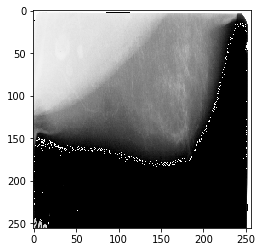

Label: [0. 1. 0. 0.]
[[[255.99609375 255.99609375 255.99609375]
  [ 65.453125    65.453125    65.453125  ]
  [ 49.328125    49.328125    49.328125  ]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 [[255.99609375 255.99609375 255.99609375]
  [ 66.97265625  66.97265625  66.97265625]
  [ 49.4609375   49.4609375   49.4609375 ]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 [[255.99609375 255.99609375 255.99609375]
  [ 64.828125    64.828125    64.828125  ]
  [ 48.546875    48.546875    48.546875  ]
  ...
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]
  [  0.           0.           0.        ]]

 ...

 [[255.99609375 255.99609375 255.99609375]
  [219.44140625 219.44140625 219.44140625]
  [218.109375   218.109375   218.109375  ]
  ...
  [  0.           0.           0.       

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 123

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

In [13]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [14]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [15]:
vgg16_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

In [17]:
vgg16_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [19]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 56.0850 - accuracy: 0.2433
Epoch 00001: val_loss improved from inf to 1.38492, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 32s 2s/step - loss: 53.1888 - accuracy: 0.2527 - val_loss: 1.3849 - val_accuracy: 0.3196
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3999 - accuracy: 0.3504
Epoch 00002: val_loss did not improve from 1.38492
19/19 [==============================] - 29s 2s/step - loss: 1.3989 - accuracy: 0.3505 - val_loss: 1.4078 - val_accuracy: 0.2990
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.4152 - accuracy: 0.3500
Epoch 00003: val_loss improved from 1.38492 to 1.38356, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================

Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2905 - accuracy: 0.3668
Epoch 00028: val_loss did not improve from 1.31411
19/19 [==============================] - 29s 2s/step - loss: 1.2899 - accuracy: 0.3681 - val_loss: 1.3295 - val_accuracy: 0.3351
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2946 - accuracy: 0.3668
Epoch 00029: val_loss did not improve from 1.31411
19/19 [==============================] - 29s 2s/step - loss: 1.2932 - accuracy: 0.3681 - val_loss: 1.3257 - val_accuracy: 0.3265
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2863 - accuracy: 0.3763
Epoch 00030: val_loss did not improve from 1.31411
19/19 [==============================] - 29s 2s/step - loss: 1.2849 - accuracy: 0.3784 - val_loss: 1.3366 - val_accuracy: 0.3351
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3011 - accuracy: 0.3704
Epoch 00031: val_loss did not improve from 1.31411
19/19 [==================

18/19 [===========================>..] - ETA: 1s - loss: 1.2777 - accuracy: 0.3976
Epoch 00057: val_loss did not improve from 1.29632
19/19 [==============================] - 29s 2s/step - loss: 1.2777 - accuracy: 0.3943 - val_loss: 1.3034 - val_accuracy: 0.3883
Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2856 - accuracy: 0.3904
Epoch 00058: val_loss did not improve from 1.29632
19/19 [==============================] - 29s 2s/step - loss: 1.2851 - accuracy: 0.3891 - val_loss: 1.3259 - val_accuracy: 0.3832
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2796 - accuracy: 0.4008
Epoch 00059: val_loss did not improve from 1.29632
19/19 [==============================] - 29s 2s/step - loss: 1.2775 - accuracy: 0.4015 - val_loss: 1.2968 - val_accuracy: 0.3866
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2632 - accuracy: 0.4094
Epoch 00060: val_loss did not improve from 1.29632
19/19 [==============================]

18/19 [===========================>..] - ETA: 1s - loss: 1.2628 - accuracy: 0.4081
Epoch 00086: val_loss did not improve from 1.28823
19/19 [==============================] - 29s 2s/step - loss: 1.2650 - accuracy: 0.4058 - val_loss: 1.3207 - val_accuracy: 0.3797
Epoch 87/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2611 - accuracy: 0.4072
Epoch 00087: val_loss did not improve from 1.28823
19/19 [==============================] - 29s 2s/step - loss: 1.2605 - accuracy: 0.4054 - val_loss: 1.3179 - val_accuracy: 0.3935
Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2593 - accuracy: 0.4090
Epoch 00088: val_loss did not improve from 1.28823
19/19 [==============================] - 29s 2s/step - loss: 1.2576 - accuracy: 0.4118 - val_loss: 1.3144 - val_accuracy: 0.4021
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2665 - accuracy: 0.4094
Epoch 00089: val_loss did not improve from 1.28823
19/19 [==============================]

Epoch 116/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2678 - accuracy: 0.4017
Epoch 00116: val_loss did not improve from 1.27650
19/19 [==============================] - 29s 2s/step - loss: 1.2644 - accuracy: 0.4024 - val_loss: 1.3162 - val_accuracy: 0.3900
Epoch 117/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2500 - accuracy: 0.4240
Epoch 00117: val_loss did not improve from 1.27650
19/19 [==============================] - 29s 2s/step - loss: 1.2508 - accuracy: 0.4239 - val_loss: 1.2891 - val_accuracy: 0.4141
Epoch 118/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2604 - accuracy: 0.4022
Epoch 00118: val_loss did not improve from 1.27650
19/19 [==============================] - 29s 2s/step - loss: 1.2610 - accuracy: 0.4037 - val_loss: 1.3187 - val_accuracy: 0.3952
Epoch 119/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2587 - accuracy: 0.3990
Epoch 00119: val_loss did not improve from 1.27650
19/19 [==============

In [20]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [21]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [22]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [23]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 120
Epoch [opt]: 90
Valid accuracy [end]: 0.3711
Valid accuracy [opt]: 0.3952
Test accuracy [end]:  0.3756
Test accuracy [opt]:  0.3527
Valid loss [end]: 1.3088
Valid loss [opt]: 1.2765
Test loss [end]:  1.2918
Test loss [opt]:  1.3637


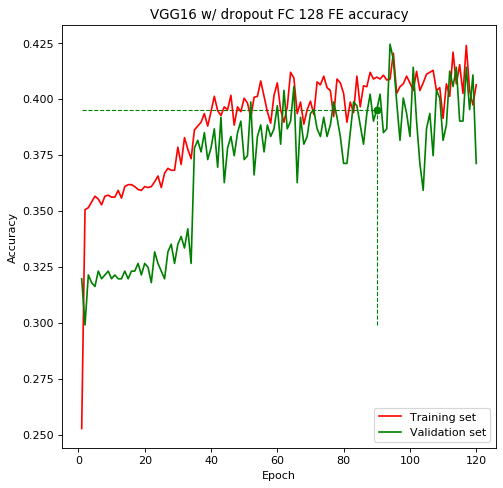

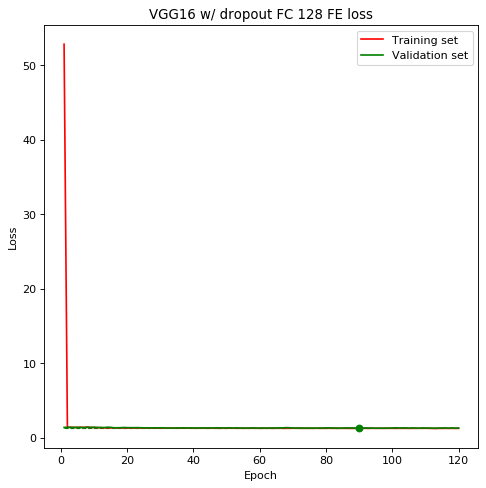

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [25]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 43.8227 - accuracy: 0.2710
Epoch 00001: val_loss improved from inf to 1.38519, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 41.6747 - accuracy: 0.2720 - val_loss: 1.3852 - val_accuracy: 0.2509
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3989 - accuracy: 0.3345
Epoch 00002: val_loss improved from 1.38519 to 1.38315, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3986 - accuracy: 0.3346 - val_loss: 1.3831 - val_accuracy: 0.3196
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.4093 - accuracy: 0.3504
Epoch 00003: val_loss did not improve from 1.38315
19/19 [==============================] - 29s 2s/step - loss: 1.4074 - accuracy: 0.3505 - val_loss: 1.3975 - val_a

Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3051 - accuracy: 0.3554
Epoch 00028: val_loss did not improve from 1.32088
19/19 [==============================] - 29s 2s/step - loss: 1.3042 - accuracy: 0.3569 - val_loss: 1.3471 - val_accuracy: 0.3196
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3093 - accuracy: 0.3577
Epoch 00029: val_loss did not improve from 1.32088
19/19 [==============================] - 29s 2s/step - loss: 1.3084 - accuracy: 0.3574 - val_loss: 1.3396 - val_accuracy: 0.3230
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3161 - accuracy: 0.3518
Epoch 00030: val_loss did not improve from 1.32088
19/19 [==============================] - 29s 2s/step - loss: 1.3135 - accuracy: 0.3561 - val_loss: 1.3283 - val_accuracy: 0.3196
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3122 - accuracy: 0.3604
Epoch 00031: val_loss did not improve from 1.32088
19/19 [==================

Epoch 57/150
18/19 [===========================>..] - ETA: 1s - loss: 1.5027 - accuracy: 0.4013
Epoch 00057: val_loss did not improve from 1.30518
19/19 [==============================] - 29s 2s/step - loss: 1.4890 - accuracy: 0.4007 - val_loss: 1.3271 - val_accuracy: 0.4055
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2781 - accuracy: 0.3985
Epoch 00058: val_loss did not improve from 1.30518
19/19 [==============================] - 29s 2s/step - loss: 1.2747 - accuracy: 0.4020 - val_loss: 1.3555 - val_accuracy: 0.3900
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2779 - accuracy: 0.3924
Epoch 00059: val_loss did not improve from 1.30518
19/19 [==============================] - 29s 2s/step - loss: 1.2921 - accuracy: 0.3912 - val_loss: 1.3156 - val_accuracy: 0.3849
Epoch 60/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2938 - accuracy: 0.3872
Epoch 00060: val_loss did not improve from 1.30518
19/19 [==================

18/19 [===========================>..] - ETA: 1s - loss: 1.2713 - accuracy: 0.4163
Epoch 00086: val_loss did not improve from 1.28693
19/19 [==============================] - 29s 2s/step - loss: 1.2718 - accuracy: 0.4157 - val_loss: 1.3552 - val_accuracy: 0.3849
Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2803 - accuracy: 0.3890
Epoch 00087: val_loss did not improve from 1.28693
19/19 [==============================] - 29s 2s/step - loss: 1.2804 - accuracy: 0.3891 - val_loss: 1.3121 - val_accuracy: 0.3900
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2747 - accuracy: 0.3985
Epoch 00088: val_loss did not improve from 1.28693
19/19 [==============================] - 29s 2s/step - loss: 1.2717 - accuracy: 0.4011 - val_loss: 1.2963 - val_accuracy: 0.3952
Epoch 89/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2574 - accuracy: 0.4031
Epoch 00089: val_loss did not improve from 1.28693
19/19 [==============================]

Epoch 116/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2642 - accuracy: 0.4058
Epoch 00116: val_loss did not improve from 1.28337
19/19 [==============================] - 29s 2s/step - loss: 1.2664 - accuracy: 0.4063 - val_loss: 1.4026 - val_accuracy: 0.3643
Epoch 117/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2587 - accuracy: 0.4271
Epoch 00117: val_loss did not improve from 1.28337
19/19 [==============================] - 29s 2s/step - loss: 1.2585 - accuracy: 0.4264 - val_loss: 1.3045 - val_accuracy: 0.3780
Epoch 118/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2669 - accuracy: 0.3990
Epoch 00118: val_loss did not improve from 1.28337
19/19 [==============================] - 29s 2s/step - loss: 1.2660 - accuracy: 0.4003 - val_loss: 1.3036 - val_accuracy: 0.4021
Epoch 119/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2609 - accuracy: 0.4049
Epoch 00119: val_loss did not improve from 1.28337
19/19 [==============

In [27]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [28]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 129
Epoch [opt]: 99
Valid accuracy [end]: 0.3814
Valid accuracy [opt]: 0.3986
Test accuracy [end]:  0.3466
Test accuracy [opt]:  0.3481
Valid loss [end]: 1.3040
Valid loss [opt]: 1.2834
Test loss [end]:  1.4425
Test loss [opt]:  1.3568


In [29]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [30]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 10,749,700
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)      

In [31]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [32]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3429 - accuracy: 0.3804
Epoch 00001: val_loss improved from inf to 1.30067, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.3415 - accuracy: 0.3767 - val_loss: 1.3007 - val_accuracy: 0.3952
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2871 - accuracy: 0.3940
Epoch 00002: val_loss did not improve from 1.30067
19/19 [==============================] - 29s 2s/step - loss: 1.2813 - accuracy: 0.3960 - val_loss: 1.3075 - val_accuracy: 0.3952
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2678 - accuracy: 0.3995
Epoch 00003: val_loss improved from 1.30067 to 1.28184, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2678 - accuracy: 0.3977 - val_loss: 1.2818 - val_accurac

Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2232 - accuracy: 0.4317
Epoch 00030: val_loss did not improve from 1.26897
19/19 [==============================] - 29s 2s/step - loss: 1.2235 - accuracy: 0.4316 - val_loss: 1.2976 - val_accuracy: 0.3797
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2206 - accuracy: 0.4380
Epoch 00031: val_loss improved from 1.26897 to 1.25818, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.2182 - accuracy: 0.4389 - val_loss: 1.2582 - val_accuracy: 0.4433
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2070 - accuracy: 0.4417
Epoch 00032: val_loss did not improve from 1.25818
19/19 [==============================] - 29s 2s/step - loss: 1.2054 - accuracy: 0.4410 - val_loss: 1.3325 - val_accuracy: 0.3866
Epoch 33/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2266 - accuracy: 0.4308
Epoch 00033: val_loss did n

18/19 [===========================>..] - ETA: 1s - loss: 1.1845 - accuracy: 0.4444
Epoch 00059: val_loss did not improve from 1.25635
19/19 [==============================] - 29s 2s/step - loss: 1.1908 - accuracy: 0.4436 - val_loss: 1.3534 - val_accuracy: 0.3935
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1985 - accuracy: 0.4494
Epoch 00060: val_loss did not improve from 1.25635
19/19 [==============================] - 29s 2s/step - loss: 1.2023 - accuracy: 0.4479 - val_loss: 1.2606 - val_accuracy: 0.4210
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1943 - accuracy: 0.4467
Epoch 00061: val_loss did not improve from 1.25635
19/19 [==============================] - 29s 2s/step - loss: 1.1931 - accuracy: 0.4436 - val_loss: 1.2610 - val_accuracy: 0.4124
Epoch 62/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2095 - accuracy: 0.4435
Epoch 00062: val_loss did not improve from 1.25635
19/19 [==============================]

Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1891 - accuracy: 0.4526
Epoch 00089: val_loss did not improve from 1.23082
19/19 [==============================] - 29s 2s/step - loss: 1.1848 - accuracy: 0.4573 - val_loss: 1.3105 - val_accuracy: 0.3935
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1776 - accuracy: 0.4548
Epoch 00090: val_loss did not improve from 1.23082
19/19 [==============================] - 29s 2s/step - loss: 1.1802 - accuracy: 0.4513 - val_loss: 1.2491 - val_accuracy: 0.4433
Epoch 91/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1910 - accuracy: 0.4539
Epoch 00091: val_loss did not improve from 1.23082
19/19 [==============================] - 29s 2s/step - loss: 1.1916 - accuracy: 0.4513 - val_loss: 1.2640 - val_accuracy: 0.4124
Epoch 92/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1757 - accuracy: 0.4562
Epoch 00092: val_loss did not improve from 1.23082
19/19 [==================

In [33]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [34]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 109
Epoch [opt]: 79
Valid accuracy [end]: 0.4347
Valid accuracy [opt]: 0.4399
Test accuracy [end]:  0.3756
Test accuracy [opt]:  0.3893
Valid loss [end]: 1.2411
Valid loss [opt]: 1.2308
Test loss [end]:  1.2572
Test loss [opt]:  1.2471


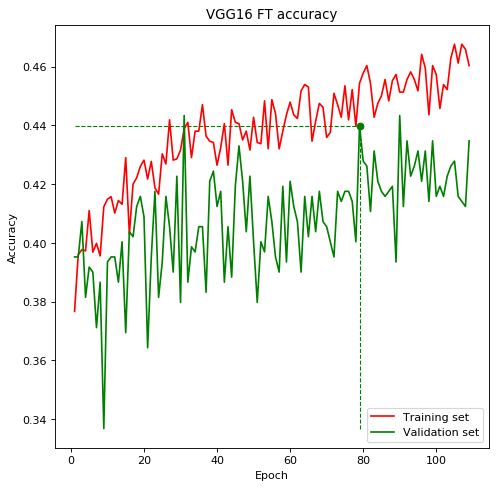

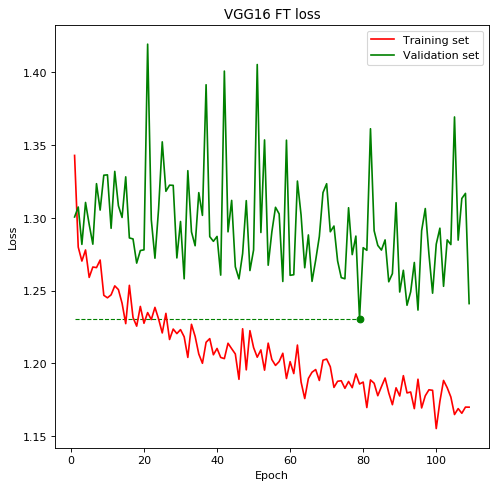

In [35]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [36]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 13,109,508
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [37]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [38]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.5357 - accuracy: 0.2569
Epoch 00001: val_loss improved from inf to 1.38052, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.5268 - accuracy: 0.2591 - val_loss: 1.3805 - val_accuracy: 0.2595
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3742 - accuracy: 0.2338
Epoch 00002: val_loss did not improve from 1.38052
19/19 [==============================] - 29s 2s/step - loss: 1.3739 - accuracy: 0.2377 - val_loss: 1.3897 - val_accuracy: 0.2835
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3127 - accuracy: 0.3536
Epoch 00003: val_loss improved from 1.38052 to 1.37473, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3171 - accuracy: 0.3492 - val_loss: 1.3747 - val_accurac

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1967 - accuracy: 0.4553
Epoch 00029: val_loss improved from 1.26356 to 1.25096, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1991 - accuracy: 0.4522 - val_loss: 1.2510 - val_accuracy: 0.4330
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2150 - accuracy: 0.4512
Epoch 00030: val_loss did not improve from 1.25096
19/19 [==============================] - 29s 2s/step - loss: 1.2189 - accuracy: 0.4474 - val_loss: 1.4027 - val_accuracy: 0.3780
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2074 - accuracy: 0.4367
Epoch 00031: val_loss did not improve from 1.25096
19/19 [==============================] - 29s 2s/step - loss: 1.2006 - accuracy: 0.4444 - val_loss: 1.3634 - val_accuracy: 0.4003
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1840 - accuracy: 0.4621
Epoch 00032: val_loss did n

18/19 [===========================>..] - ETA: 1s - loss: 1.1364 - accuracy: 0.4848
Epoch 00058: val_loss did not improve from 1.24055
19/19 [==============================] - 29s 2s/step - loss: 1.1403 - accuracy: 0.4805 - val_loss: 1.3703 - val_accuracy: 0.4124
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1758 - accuracy: 0.4616
Epoch 00059: val_loss did not improve from 1.24055
19/19 [==============================] - 29s 2s/step - loss: 1.1786 - accuracy: 0.4616 - val_loss: 1.2466 - val_accuracy: 0.4330
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1489 - accuracy: 0.4725
Epoch 00060: val_loss did not improve from 1.24055
19/19 [==============================] - 29s 2s/step - loss: 1.1554 - accuracy: 0.4689 - val_loss: 1.2840 - val_accuracy: 0.4038
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1680 - accuracy: 0.4775
Epoch 00061: val_loss did not improve from 1.24055
19/19 [==============================]

Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1471 - accuracy: 0.4730
Epoch 00088: val_loss did not improve from 1.22332
19/19 [==============================] - 29s 2s/step - loss: 1.1448 - accuracy: 0.4728 - val_loss: 1.2242 - val_accuracy: 0.4399
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1123 - accuracy: 0.4871
Epoch 00089: val_loss improved from 1.22332 to 1.22235, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1111 - accuracy: 0.4882 - val_loss: 1.2224 - val_accuracy: 0.4278
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1258 - accuracy: 0.4826
Epoch 00090: val_loss did not improve from 1.22235
19/19 [==============================] - 29s 2s/step - loss: 1.1228 - accuracy: 0.4822 - val_loss: 1.4218 - val_accuracy: 0.4141
Epoch 91/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1614 - accuracy: 0.4698
Epoch 00091: val_loss did n

18/19 [===========================>..] - ETA: 1s - loss: 1.1274 - accuracy: 0.4775
Epoch 00117: val_loss did not improve from 1.21797
19/19 [==============================] - 29s 2s/step - loss: 1.1313 - accuracy: 0.4753 - val_loss: 1.2476 - val_accuracy: 0.4502
Epoch 118/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1064 - accuracy: 0.4952
Epoch 00118: val_loss did not improve from 1.21797
19/19 [==============================] - 29s 2s/step - loss: 1.1056 - accuracy: 0.4976 - val_loss: 1.3566 - val_accuracy: 0.4192
Epoch 119/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1108 - accuracy: 0.4970
Epoch 00119: val_loss did not improve from 1.21797
19/19 [==============================] - 29s 2s/step - loss: 1.1083 - accuracy: 0.4994 - val_loss: 1.2613 - val_accuracy: 0.4622
Epoch 120/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1070 - accuracy: 0.5009
Epoch 00120: val_loss did not improve from 1.21797
19/19 [============================

In [39]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [40]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 122
Epoch [opt]: 92
Valid accuracy [end]: 0.4519
Valid accuracy [opt]: 0.4467
Test accuracy [end]:  0.3908
Test accuracy [opt]:  0.3847
Valid loss [end]: 1.2490
Valid loss [opt]: 1.2180
Test loss [end]:  1.2891
Test loss [opt]:  1.2621


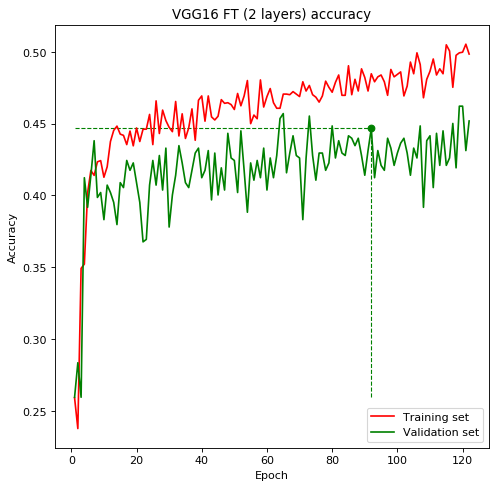

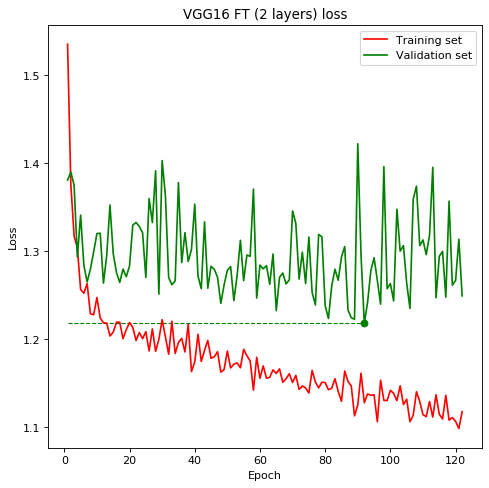

In [41]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [42]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 15,469,316
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [43]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [44]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0894 - accuracy: 0.4925
Epoch 00001: val_loss improved from inf to 1.31475, saving model to vgg16_ft_3layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.0872 - accuracy: 0.4968 - val_loss: 1.3148 - val_accuracy: 0.4450
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0889 - accuracy: 0.4984
Epoch 00002: val_loss improved from 1.31475 to 1.28333, saving model to vgg16_ft_3layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.0922 - accuracy: 0.4942 - val_loss: 1.2833 - val_accuracy: 0.4399
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0774 - accuracy: 0.5016
Epoch 00003: val_loss did not improve from 1.28333
19/19 [==============================] - 29s 2s/step - loss: 1.0733 - accuracy: 0.5045 - val_loss: 1.2859 - val_accurac

18/19 [===========================>..] - ETA: 1s - loss: 1.0565 - accuracy: 0.5184
Epoch 00029: val_loss did not improve from 1.21113
19/19 [==============================] - 29s 2s/step - loss: 1.0572 - accuracy: 0.5174 - val_loss: 1.2337 - val_accuracy: 0.4708
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0750 - accuracy: 0.5061
Epoch 00030: val_loss did not improve from 1.21113
19/19 [==============================] - 29s 2s/step - loss: 1.0711 - accuracy: 0.5079 - val_loss: 1.3221 - val_accuracy: 0.4450
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0565 - accuracy: 0.5089
Epoch 00031: val_loss did not improve from 1.21113
19/19 [==============================] - 29s 2s/step - loss: 1.0613 - accuracy: 0.5062 - val_loss: 1.2460 - val_accuracy: 0.4708
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0589 - accuracy: 0.5061
Epoch 00032: val_loss did not improve from 1.21113
19/19 [==============================]

In [45]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [46]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 40
Epoch [opt]: 10
Valid accuracy [end]: 0.4450
Valid accuracy [opt]: 0.4605
Test accuracy [end]:  0.3878
Test accuracy [opt]:  0.3847
Valid loss [end]: 1.2493
Valid loss [opt]: 1.2111
Test loss [end]:  1.2729
Test loss [opt]:  1.2793


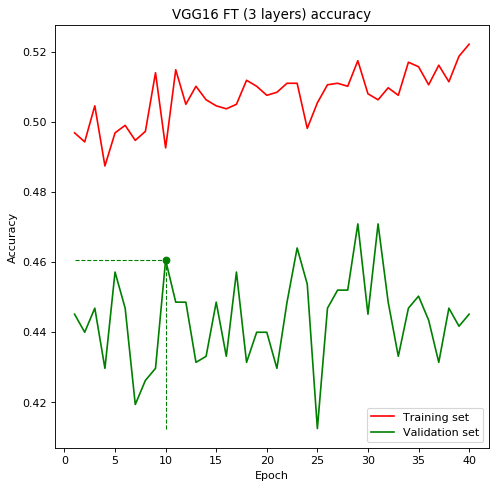

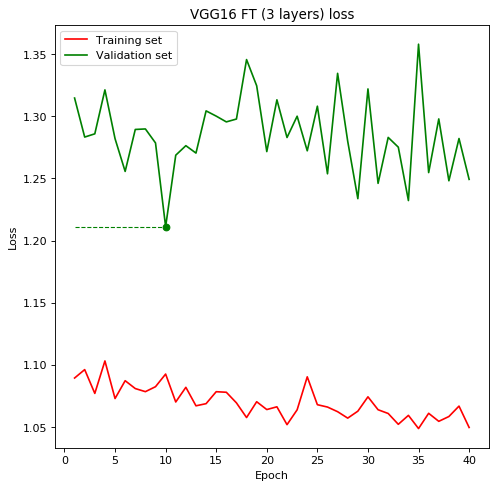

In [47]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();